### Reading Data

In [4]:
import pandas as pd

train_df = pd.read_csv("new_train.csv", index_col=0)
test_df = pd.read_csv("new_test.csv", index_col=0)

print("Train size", len(train_df))
print("Test size", len(test_df))
train_df.head(n=3)

Train size 3969
Test size 997


,medical_specialty,transcription,labels
0,Emergency Room Reports,"REASON FOR THE VISIT:, Very high PT/INR.,HIST...",0
1,Surgery,"PREOPERATIVE DIAGNOSIS:, Acetabular fracture ...",1
2,Surgery,"NAME OF PROCEDURE,1. Selective coronary angio...",1


### Train Set Label Distribution

In [5]:
train_df["medical_specialty"].value_counts()

 Surgery                          863
 Consult - History and Phy.       410
 Cardiovascular / Pulmonary       309
 Orthopedic                       289
 Radiology                        213
 General Medicine                 209
 Gastroenterology                 176
 Neurology                        170
 SOAP / Chart / Progress Notes    135
 Urology                          134
 Obstetrics / Gynecology          123
 Discharge Summary                 87
 ENT - Otolaryngology              82
 Neurosurgery                      71
 Hematology - Oncology             68
 Ophthalmology                     67
 Emergency Room Reports            63
 Nephrology                        63
 Pediatrics - Neonatal             55
 Pain Management                   54
 Psychiatry / Psychology           45
 Office Notes                      38
 Podiatry                          35
 Dermatology                       21
 Dentistry                         21
 Cosmetic / Plastic Surgery        19
 Letters    

### Sample Transcription

In [6]:
from pprint import pprint
pprint(train_df.transcription[0])

('REASON FOR THE VISIT:,  Very high PT/INR.,HISTORY: , The patient is an '
 '81-year-old lady whom I met last month when she came in with pneumonia and '
 'CHF.  She was noticed to be in atrial fibrillation, which is a chronic '
 'problem for her.  She did not want to have Coumadin started because she said '
 'that she has had it before and the INR has had been very difficult to '
 'regulate to the point that it was dangerous, but I convinced her to restart '
 'the Coumadin again.  I gave her the Coumadin as an outpatient and then the '
 'INR was found to be 12.  So, I told her to come to the emergency room to get '
 'vitamin K to reverse the anticoagulation.,PAST MEDICAL HISTORY:,1.  '
 'Congestive heart failure.,2.  Renal insufficiency.,3.  Coronary artery '
 'disease.,4.  Atrial fibrillation.,5.  COPD.,6.  Recent pneumonia.,7.  '
 'Bladder cancer.,8.  History of ruptured colon.,9.  Myocardial '
 'infarction.,10.  Hernia repair.,11.  Colon resection.,12.  Carpal tunnel '
 'repair.,13

# My Training Model

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE


In [8]:
# Unique words
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [17]:
# Sentenece and Unique Words count
print(train_df.columns)
train_df.head(5)
train_df = train_df[train_df['transcription'].notna()]
# sent_count,word_count= get_sentence_word_count(train_df.transcription)
# print("Number of sentences in transcriptions column: "+ str(sent_count))
# print("Number of unique words in transcriptions column: "+str(word_count))

data_categories  = train_df.groupby(train_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Index(['medical_specialty', 'transcription', 'labels'], dtype='object')
===========Original Categories =======================
Cat:1  Allergy / Immunology : 6
Cat:2  Autopsy : 7
Cat:3  Bariatrics : 15
Cat:4  Cardiovascular / Pulmonary : 309
Cat:5  Chiropractic : 12
Cat:6  Consult - History and Phy. : 410
Cat:7  Cosmetic / Plastic Surgery : 19
Cat:8  Dentistry : 21
Cat:9  Dermatology : 21
Cat:10  Diets and Nutritions : 9
Cat:11  Discharge Summary : 87
Cat:12  ENT - Otolaryngology : 82
Cat:13  Emergency Room Reports : 63
Cat:14  Endocrinology : 16
Cat:15  Gastroenterology : 176
Cat:16  General Medicine : 209
Cat:17  Hematology - Oncology : 68
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 12
Cat:20  Lab Medicine - Pathology : 5
Cat:21  Letters : 19
Cat:22  Nephrology : 63
Cat:23  Neurology : 170
Cat:24  Neurosurgery : 71
Cat:25  Obstetrics / Gynecology : 123
Cat:26  Office Notes : 38
Cat:27  Ophthalmology : 67
Cat:28  Orthopedic : 289
Cat:29  Pain Management : 54


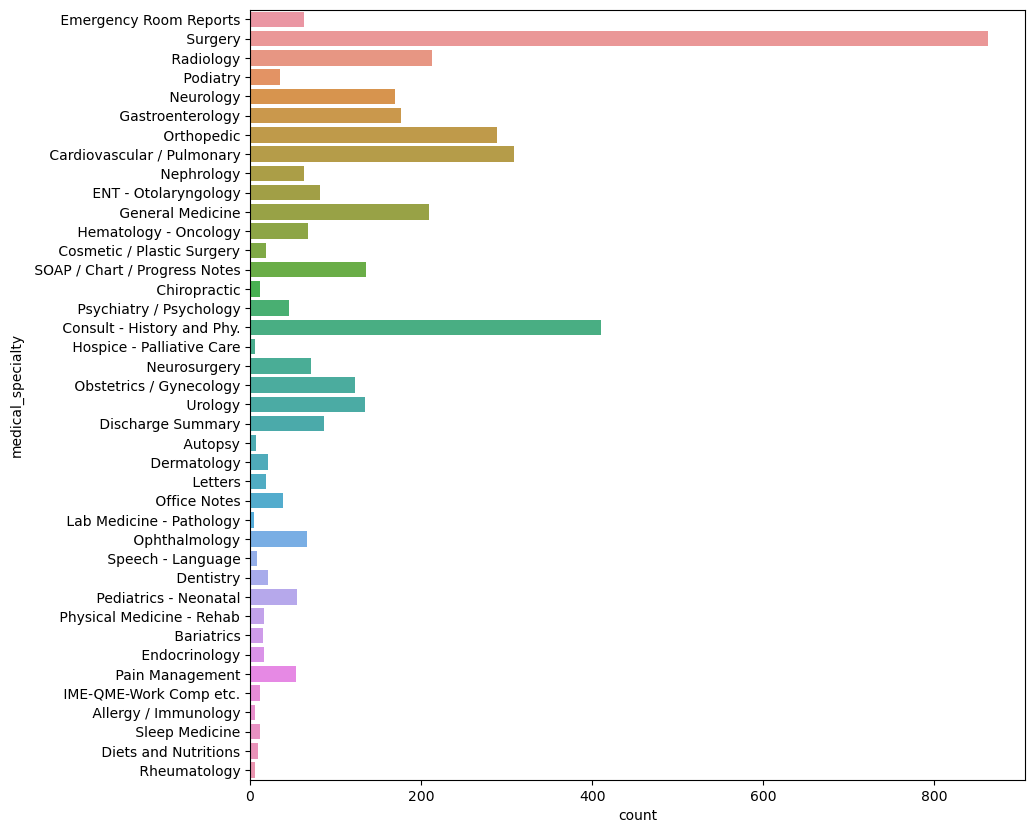

In [18]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = train_df )
plt.show()

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 309
Cat:2  Consult - History and Phy. : 410
Cat:3  Discharge Summary : 87
Cat:4  ENT - Otolaryngology : 82
Cat:5  Emergency Room Reports : 63
Cat:6  Gastroenterology : 176
Cat:7  General Medicine : 209
Cat:8  Hematology - Oncology : 68
Cat:9  Nephrology : 63
Cat:10  Neurology : 170
Cat:11  Neurosurgery : 71
Cat:12  Obstetrics / Gynecology : 123
Cat:13  Ophthalmology : 67
Cat:14  Orthopedic : 289
Cat:15  Pain Management : 54
Cat:16  Pediatrics - Neonatal : 55
Cat:17  Radiology : 213
Cat:18  SOAP / Chart / Progress Notes : 135
Cat:19  Surgery : 863
Cat:20  Urology : 134
============ Reduced Categories ======================
                                          transcription  \
0     REASON FOR THE VISIT:,  Very high PT/INR.,HIST...   
1     PREOPERATIVE DIAGNOSIS:,  Acetabular fracture ...   
2     NAME OF PROCEDURE,1.  Selective coronary angio...   
3     REFERRING DIAGNOSIS: , Motor neuron di

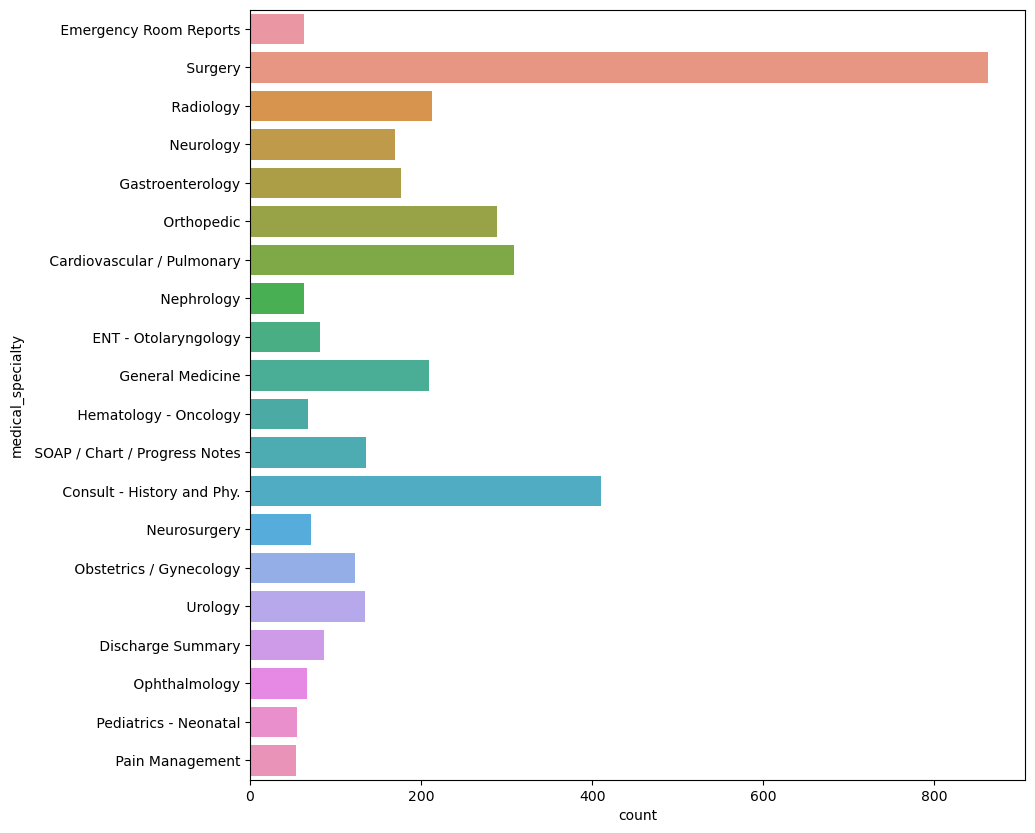

In [19]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
print(data)
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [20]:
# helper functions
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

In [21]:

data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/jaimil.d/nltk_data'
    - '/Users/jaimil.d/opt/anaconda3/nltk_data'
    - '/Users/jaimil.d/opt/anaconda3/share/nltk_data'
    - '/Users/jaimil.d/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [22]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:HISTORY:,  The patient is a 25-year-old gentleman who was seen in the emergency room at Children's Hospital today.  He brought his 3-month-old daughter in for evaluation but also wanted to be evaluated himself because he has had "rib cage pain" for the last few days.  He denies any history of trauma.  He does have increased pain with laughing.  Per the patient, he also claims to have an elevated temperature yesterday of 101.  Apparently, the patient did go to the emergency room at ABCD yesterday, but due to the long wait, he left without actually being evaluated and then thought that he might be seen today when he came to Children's.,PAST MEDICAL HISTORY: , The patient has a medical history significant for "Staphylococcus infection" that was being treated with antibiotics for 10 days.,CURRENT MEDICATIONS: , He states that he is currently taking no medications.,ALLERGIES:  ,He is not allergic to any medication.,PAST SURGICAL HISTORY: , He denies any past surgical 

In [101]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['000', '07', '08', '10', '10 mg', '100', '11', '12', '13', '14', '15', '15 blade', '16', '17', '18', '19', '20', '20 mg', '2007', '2008', '22', '24', '25', '26', '30', '40', '50', '60', '70', '80', '90', '95', 'abc', 'abdomen', 'abdomen soft', 'abdomen soft nontender', 'abdominal', 'abdominal pain', 'able', 'abnormal', 'abnormalities', 'achieved', 'active', 'activity', 'acute', 'acute distress', 'addition', 'additional', 'adequate', 'adhesions', 'administered', 'admission', 'admitted', 'advanced', 'age', 'ago', 'air', 'alcohol', 'alert', 'alert oriented', 'allergies', 'allergies known', 'anastomosis', 'anemia', 'anesthesia', 'anesthesia general', 'anesthesia general endotracheal', 'anesthetic', 'ankle', 'anterior', 'anterior descending', 'anteriorly', 'antibiotic', 'antibiotics', 'aorta', 'aortic', 'appear', 'appearance', 'appeared', 'appearing', 'appears', 'applied', 'appropriate', 'approximately', 'approximately cm', 'area', 'areas', 'arm', 'artery', 'artery disease', 'asked', 'aspe

/Users/jaimil.d/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/Users/jaimil.d/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/jaimil.d/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


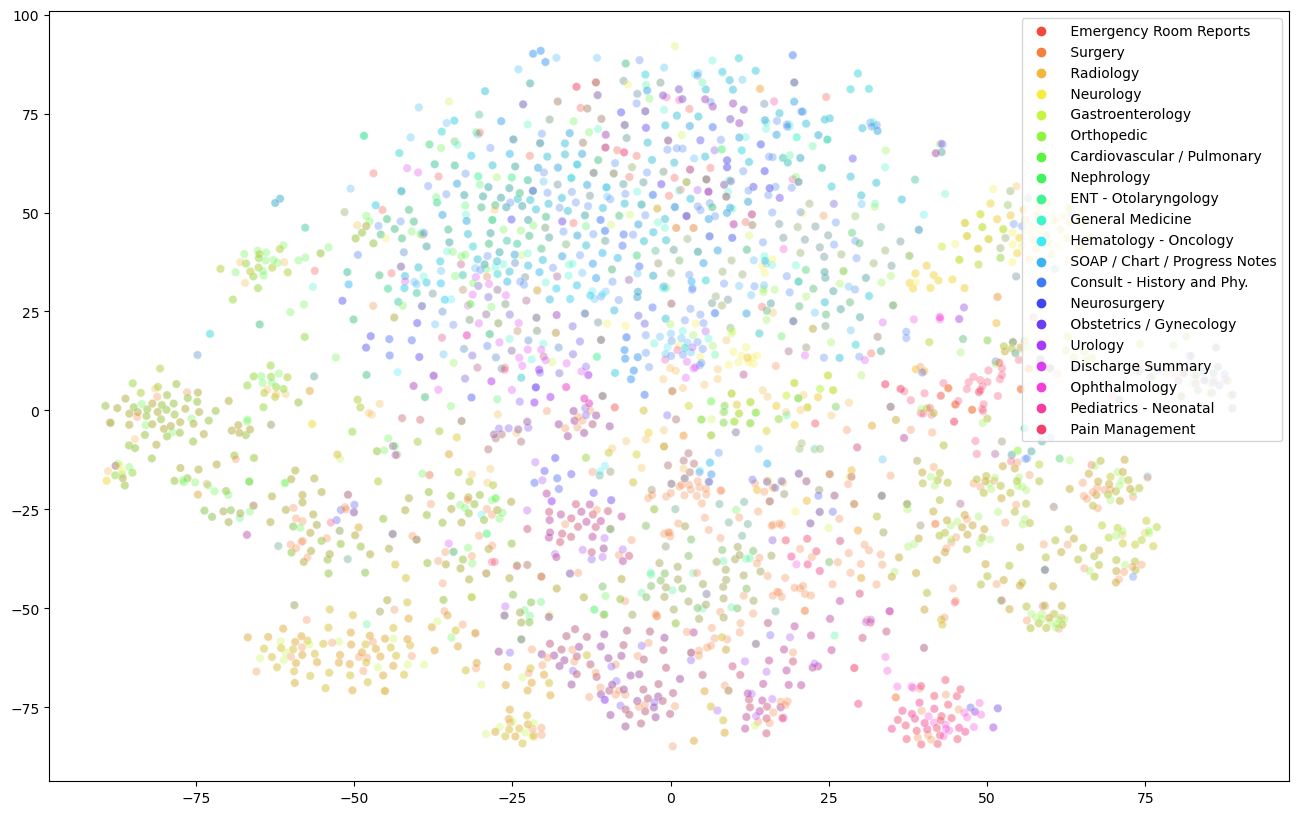

In [102]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(16,10))
palette = sns.hls_palette(20, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [103]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from torch import nn
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
gc.collect()
pca = PCA(n_components=1)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())

labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()



tfIdfMat_test = vectorizer.fit_transform(test_df['transcription'].tolist())
tfIdfMat_reduced_test = pca.fit_transform(tfIdfMat_test.toarray())

# X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)
train_train_df, train_test_df = \
    train_test_split(
    train_df,
    test_size=0.3,
    random_state=20
)
ds_dict = {
    'train': Dataset.from_pandas(train_train_df),
    'val': Dataset.from_pandas(train_test_df),
    "test": Dataset.from_pandas(test_df)
}
ds = DatasetDict(ds_dict)
# model_name = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# def tokenize_text(texts):
#     return tokenizer(texts["transcription"], truncation=True, padding=True, max_length=256)

# ds["train"] = ds["train"].map(tokenize_text, batched=True)
# ds["val"] = ds["val"].map(tokenize_text, batched=True)
# ds["test"] = ds["test"].map(tokenize_text, batched=True)
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)   

# X_train, X_test, y_train, y_test = tfIdfMat_reduced, tfIdfMat_reduced_test, stratify=category_list, stratify=category_list
# X_train, X_test, y_train, y_test = ds['train'], ds['test'], labels, labels

In [104]:
print('Train_Set_Size:'+str(X_train.shape))
print(X_train)
print('Test_Set_Size:'+str(X_test.shape))
print(X_test)

Train_Set_Size:(2730, 1)
[[-0.14706328]
 [ 0.29840509]
 [-0.05929918]
 ...
 [-0.02751564]
 [ 0.06290458]
 [-0.28527801]]
Test_Set_Size:(911, 1)
[[ 3.30810340e-01]
 [-2.85084915e-01]
 [-3.07650090e-01]
 [ 3.58368047e-01]
 [ 3.94603972e-01]
 [-1.68493960e-01]
 [-2.32317497e-01]
 [ 6.98035412e-02]
 [-1.58719156e-01]
 [-9.01349101e-02]
 [-1.62409468e-01]
 [-2.66769453e-01]
 [ 9.69000247e-03]
 [ 3.75981702e-01]
 [ 1.66468374e-02]
 [-2.32043086e-01]
 [ 2.72144992e-01]
 [-2.42164690e-01]
 [-1.75165543e-01]
 [-1.46100681e-01]
 [ 6.39015174e-02]
 [-2.42047814e-01]
 [ 3.18438321e-01]
 [-3.18353257e-02]
 [ 2.91483636e-01]
 [ 2.62205345e-01]
 [ 4.20963328e-01]
 [-1.32849339e-01]
 [-1.95718962e-01]
 [-2.07664084e-01]
 [ 3.63563682e-01]
 [-1.68916198e-01]
 [-2.50731151e-04]
 [ 8.07997745e-02]
 [-2.78362274e-01]
 [ 4.18690015e-01]
 [-1.90961235e-01]
 [-1.62409468e-01]
 [-7.29068549e-02]
 [ 6.45568805e-02]
 [-1.95435728e-02]
 [ 3.77610389e-01]
 [-1.06595380e-02]
 [-2.02097712e-01]
 [ 8.65643434e-03]
 

In [105]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

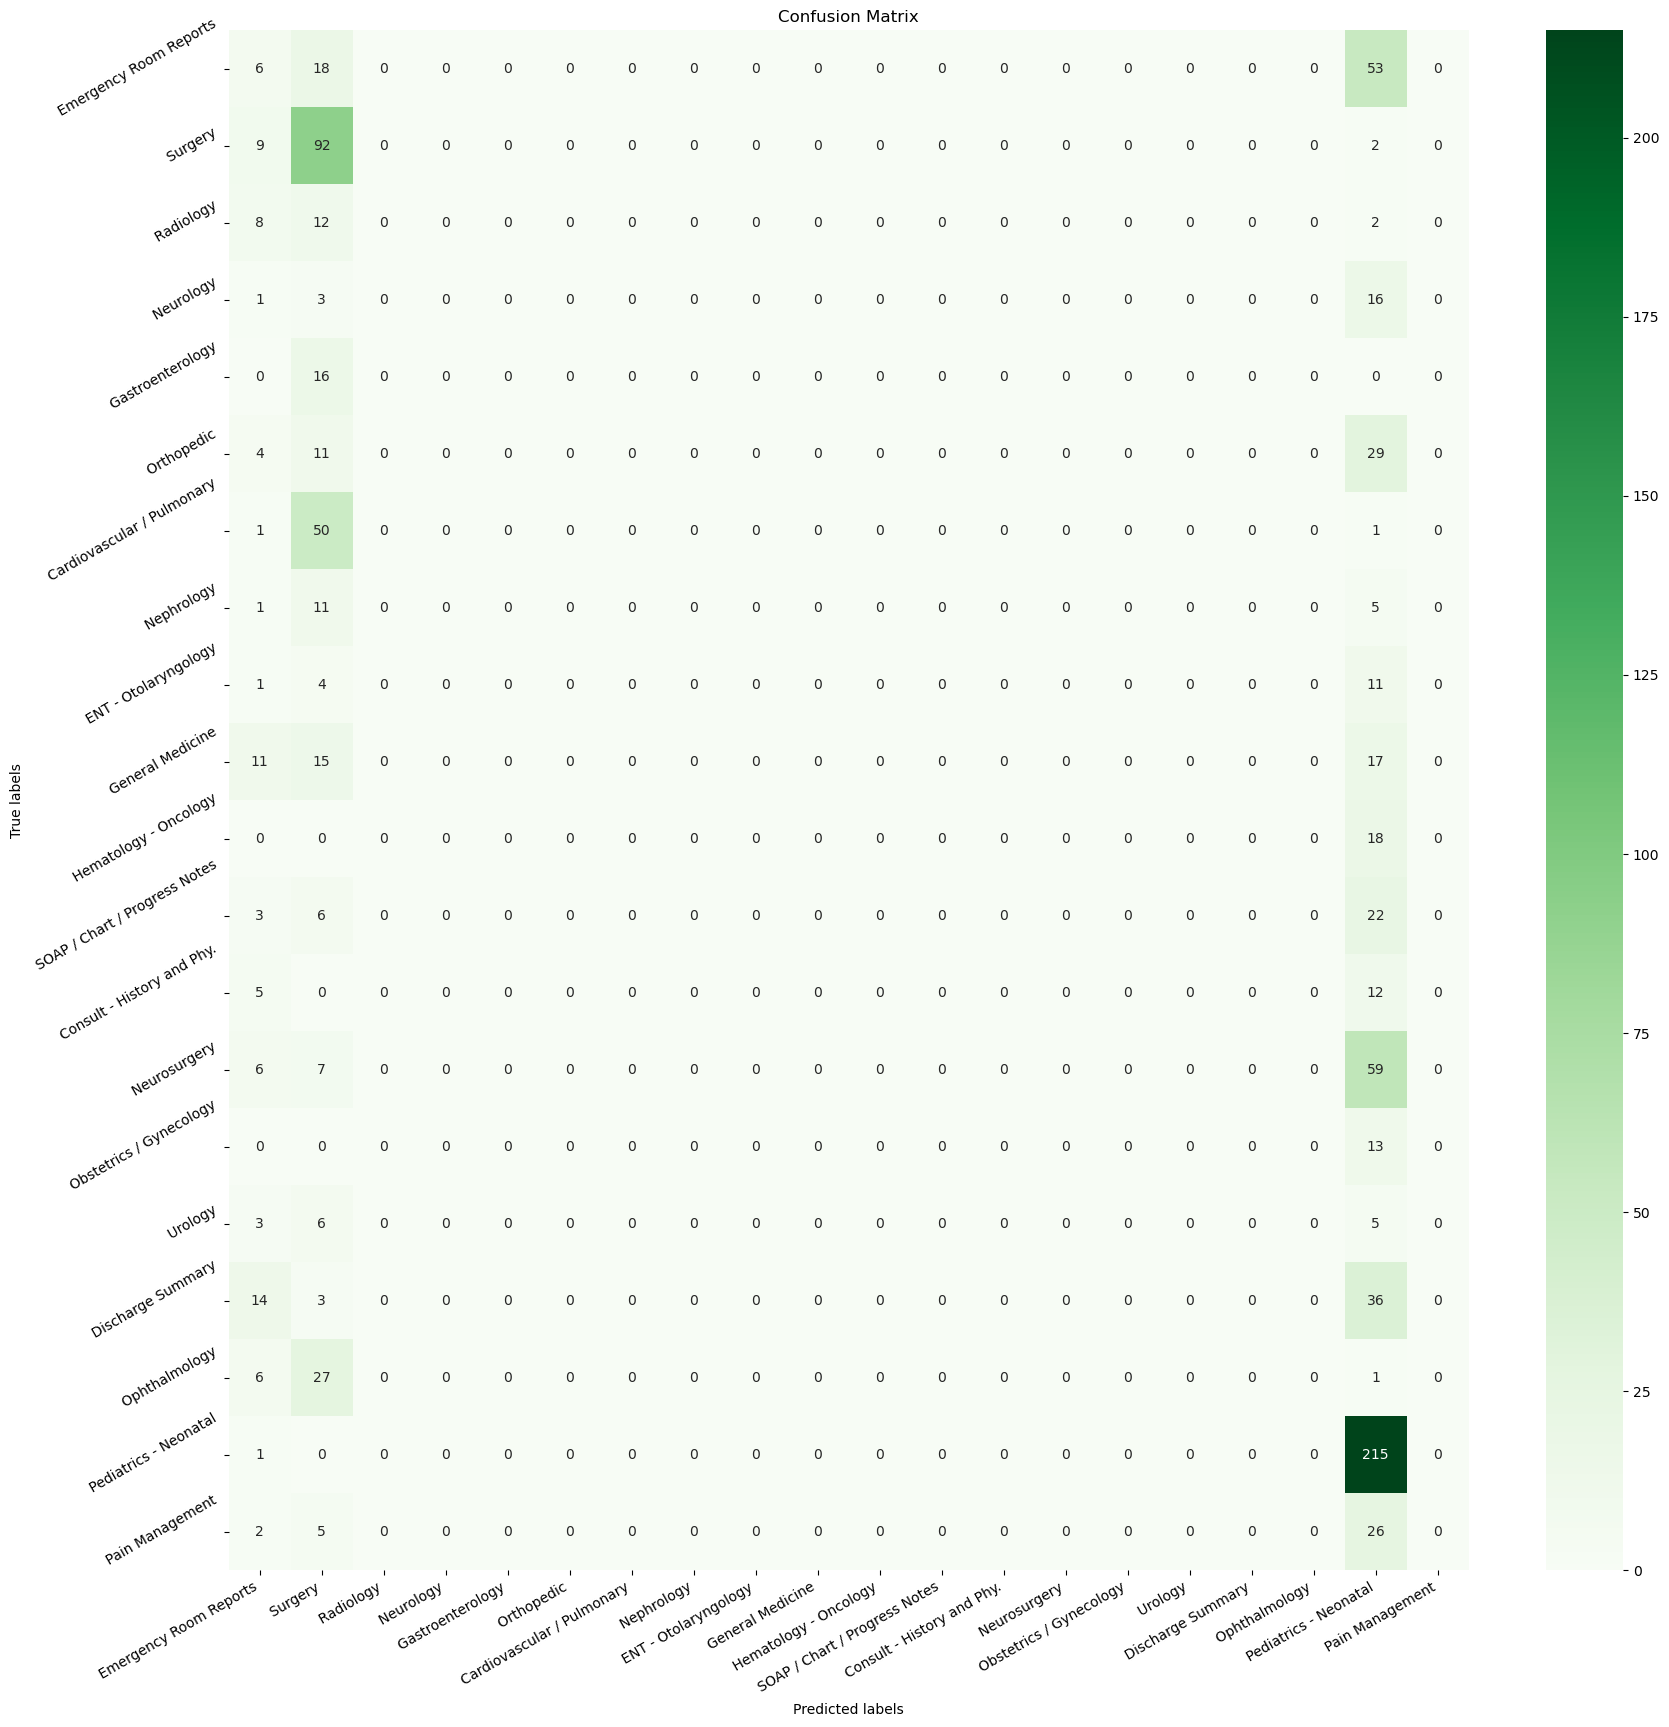

In [106]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [107]:
print(classification_report(y_test,y_test_pred,labels=category_list))


                                precision    recall  f1-score   support

        Emergency Room Reports       0.00      0.00      0.00        16
                       Surgery       0.40      1.00      0.57       216
                     Radiology       0.00      0.00      0.00        53
                     Neurology       0.00      0.00      0.00        43
              Gastroenterology       0.00      0.00      0.00        44
                    Orthopedic       0.00      0.00      0.00        72
    Cardiovascular / Pulmonary       0.07      0.08      0.08        77
                    Nephrology       0.00      0.00      0.00        16
          ENT - Otolaryngology       0.00      0.00      0.00        20
              General Medicine       0.00      0.00      0.00        52
         Hematology - Oncology       0.00      0.00      0.00        17
 SOAP / Chart / Progress Notes       0.00      0.00      0.00        34
    Consult - History and Phy.       0.32      0.89      0.47  

/Users/jaimil.d/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaimil.d/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaimil.d/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
# This is where the error is
tfIdfMat_testset = vectorizer.fit_transform(test_df['transcription'].tolist())
tfIdfMat_reduced_testset = pca.transform(tfIdfMat_testset.toarray())
print(tfIdfMat_reduced_testset.shape)
pred_y = clf.predict(tfIdfMat_reduced_testset)
print(pred_y)
a = pd.Series(pred_y)
a.name = "Expected"
a.to_csv("predictions.csv")


(997, 1)
[' Consult - History and Phy.' ' Consult - History and Phy.' ' Surgery'
 ' Surgery' ' Surgery' ' Consult - History and Phy.'
 ' Consult - History and Phy.' ' Surgery' ' Surgery'
 ' Consult - History and Phy.' ' Cardiovascular / Pulmonary' ' Surgery'
 ' Consult - History and Phy.' ' Surgery' ' Consult - History and Phy.'
 ' Surgery' ' Surgery' ' Surgery' ' Cardiovascular / Pulmonary' ' Surgery'
 ' Consult - History and Phy.' ' Cardiovascular / Pulmonary'
 ' Consult - History and Phy.' ' Consult - History and Phy.'
 ' Consult - History and Phy.' ' Surgery' ' Surgery' ' Surgery'
 ' Cardiovascular / Pulmonary' ' Surgery' ' Surgery'
 ' Cardiovascular / Pulmonary' ' Surgery' ' Surgery'
 ' Consult - History and Phy.' ' Consult - History and Phy.' ' Surgery'
 ' Surgery' ' Consult - History and Phy.' ' Consult - History and Phy.'
 ' Consult - History and Phy.' ' Consult - History and Phy.' ' Surgery'
 ' Consult - History and Phy.' ' Surgery' ' Cardiovascular / Pulmonary'
 ' Consult - H

### Sample Training

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from torch import nn
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

In [ ]:
unique_classes = train_df["medical_specialty"].unique()

# idx_2_class = {i: s for i, s in enumerate(unique_classes)}
# class_2_idx = {s: i for i, s in enumerate(unique_classes)}

In [ ]:
# train_df["labels"] = train_df["medical_specialty"].apply(lambda s: class_2_idx[s])

In [ ]:
train_train_df, train_test_df = \
    train_test_split(
    train_df,
    test_size=0.3,
    random_state=42
)

In [ ]:
ds_dict = {
    'train': Dataset.from_pandas(train_train_df),
    'val': Dataset.from_pandas(train_test_df),
    "test": Dataset.from_pandas(test_df)
}

ds = DatasetDict(ds_dict)

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_text(texts):
    return tokenizer(texts["transcription"], truncation=True, padding=True, max_length=256)

ds["train"] = ds["train"].map(tokenize_text, batched=True)
ds["val"] = ds["val"].map(tokenize_text, batched=True)
ds["test"] = ds["test"].map(tokenize_text, batched=True)

Map:   0%|          | 0/2778 [00:00<?, ? examples/s]

Map:   0%|          | 0/1191 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(unique_classes)
)

NameError: name 'AutoModelForSequenceClassification' is not defined

### Evaluation Metric

In [ ]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    return {"f1": f1}

In [ ]:
batch_size = 32
logging_steps = len(train_train_df) // batch_size
output_dir = "hf_trainer"

training_args = TrainingArguments(
    output_dir=output_dir,
     num_train_epochs=5,
     learning_rate=2e-5,
     per_device_train_batch_size=batch_size,
     per_device_eval_batch_size=batch_size,
     weight_decay=0.01,
     evaluation_strategy="epoch",
     logging_steps=logging_steps,
     push_to_hub=False
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds['train'],
    eval_dataset=ds['val'],
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, medical_specialty, transcription. If __index_level_0__, medical_specialty, transcription are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\alvin\miniconda3\envs\hf\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2778
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 435
You're using a DistilBertTokenizerFast tokenizer. Please note that 

Epoch,Training Loss,Validation Loss,F1
1,3.045300,2.807685,0.024263
2,2.583900,2.633775,0.036012
3,2.438700,2.529113,0.050857
4,2.344900,2.458471,0.053919
5,2.267800,2.432428,0.054719


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, medical_specialty, transcription. If __index_level_0__, medical_specialty, transcription are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1191
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, medical_specialty, transcription. If __index_level_0__, medical_specialty, transcription are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1191
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` a

TrainOutput(global_step=435, training_loss=2.5318976632479964, metrics={'train_runtime': 403.981, 'train_samples_per_second': 34.383, 'train_steps_per_second': 1.077, 'total_flos': 920609536204800.0, 'train_loss': 2.5318976632479964, 'epoch': 5.0})

### Making Inference on the Test Set

In [ ]:
ds["test"]

Dataset({
    features: ['transcription', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 997
})

In [ ]:
pred_y = trainer.predict(ds["test"])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, transcription. If __index_level_0__, transcription are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 997
  Batch size = 32


In [ ]:
a = pd.Series(pred_y.predictions.argmax(axis=1))
a.name = "Expected"
a.to_csv("predictions.csv")